# SBERT Baseline - Semantic Video Retrieval

**Goal**: Rank videos by semantic similarity to skills using SBERT embeddings.

**Approach**:
1. Generate embeddings for skill descriptions
2. Generate embeddings for all transcript chunks
3. Compute cosine similarity between skills and chunks
4. Aggregate chunk similarities to video level
5. Rank videos by similarity score

## Setup

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results/baselines')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

c:\Users\jaime\OneDrive\BU\1st Semester\Deep Learning\Deep Learning Project\Deep-Learning-Project\dl-project-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
TOP_K_CHUNKS = 5
print(f"Using top-{TOP_K_CHUNKS} chunk average for video-level scores.")

Using top-5 chunk average for video-level scores.


## Load Data

In [ ]:
# Load chunks and video metadata
chunks_df = pd.read_csv(DATA_DIR / 'transcript_chunks.csv')
videos_df = pd.read_csv(DATA_DIR / 'videos_filtered.csv')

# Load skill definitions
import yaml
with open('../config/skills.yml', 'r') as f:
    skills_config = yaml.safe_load(f)

print(f"Loaded {len(chunks_df):,} chunks from {len(videos_df)} videos")
print(f"Skills: {len(skills_config['skills'])}")
print(f"\nSkill list:")
for skill in skills_config['skills']:
    print(f"  - {skill['skill_id']}: {skill['name']}")

Loaded 12,170 chunks from 414 videos
Skills: 8

Skill list:
  - numpy_array_manipulation: NumPy array manipulation
  - pandas_data_cleaning: Pandas data cleaning
  - matplotlib_visualization: Matplotlib data visualization
  - sklearn_model_training: Scikit-learn model training
  - pytorch_neural_networks: PyTorch neural network basics
  - tensorflow_image_classification: TensorFlow image classification
  - feature_engineering: Feature engineering for ML
  - model_evaluation_metrics: Model evaluation metrics


---
## Step 1: Load SBERT Model

Using the same model from Module 2 chunking.

In [ ]:
from sentence_transformers import SentenceTransformer

# Load SBERT model
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'

print(f"Loading SBERT model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)

print(f" Model loaded")
print(f"   Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"   Max sequence length: {model.max_seq_length}")

---
## Step 2: Generate Skill Embeddings

In [ ]:
# Create skill texts
skill_texts = []
skill_ids = []

for skill in skills_config['skills']:
    # Combine name and description
    skill_text = f"{skill['name']}. {skill['description']}"
    skill_texts.append(skill_text)
    skill_ids.append(skill['skill_id'])

print("Example skill text:")
print(f"  {skill_ids[0]}:")
print(f"  {skill_texts[0][:200]}...")

Example skill text:
  numpy_array_manipulation:
  NumPy array manipulation. Learn how to create, manipulate, and operate on NumPy arrays including indexing, slicing, reshaping, broadcasting, and performing mathematical operations on multidimensional ...


In [ ]:
# Generate embeddings for all skills
print(f"Encoding {len(skill_texts)} skill descriptions...")
skill_embeddings = model.encode(skill_texts, show_progress_bar=True, convert_to_numpy=True)

print(f"Skill embeddings generated")
print(f"   Shape: {skill_embeddings.shape}")

# Save embeddings
np.save(DATA_DIR / 'skill_embeddings.npy', skill_embeddings)
pd.DataFrame({'skill_id': skill_ids}).to_csv(DATA_DIR / 'skill_embedding_index.csv', index=False)

print(f"Saved to {DATA_DIR / 'skill_embeddings.npy'}")

---
## Step 3: Generate Chunk Embeddings



In [ ]:
# Check if embeddings already exist
embeddings_path = DATA_DIR / 'chunk_embeddings.npy'

if embeddings_path.exists():
    print(f"Loading existing chunk embeddings from {embeddings_path}...")
    chunk_embeddings = np.load(embeddings_path)
    print(f"Loaded chunk embeddings: {chunk_embeddings.shape}")
else:
    print(f"Encoding {len(chunks_df):,} chunks...")


    # Encode in batches for better progress tracking
    chunk_embeddings = model.encode(
        chunks_df['text'].tolist(),
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    print(f"Chunk embeddings generated")
    print(f"   Shape: {chunk_embeddings.shape}")

    # Save embeddings
    np.save(embeddings_path, chunk_embeddings)
    print(f" Saved to {embeddings_path}")

In [ ]:
# Ensure chunk_embeddings is available even if the previous cell was skipped
if 'chunk_embeddings' not in globals():
    chunk_embeddings = np.load(DATA_DIR / 'chunk_embeddings.npy')
    print("chunk_embeddings loaded from disk for ranking")

---
## Step 4: Compute Similarities (No FAISS)

compute cosine similarity using NumPy, then aggregate to video-level
by averaging the top `TOP_K_CHUNKS` chunk scores.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def rank_videos_sbert(
    skill_embedding: np.ndarray,
    chunk_embeddings: np.ndarray,
    chunks_df: pd.DataFrame,
    aggregation: str = 'mean_topk',
    top_k_chunks: int = TOP_K_CHUNKS
):
    """
    Rank videos using SBERT cosine similarity.

    Args:
        skill_embedding: Single skill embedding (1D array)
        chunk_embeddings: All chunk embeddings (2D array)
        chunks_df: DataFrame with chunk metadata
        aggregation: How to aggregate chunk scores ('mean_topk' or 'max')
        top_k_chunks: If using mean_topk, how many top chunks to average

    Returns:
        DataFrame with ranked videos
        DataFrame with chunk scores
    """
    top_k_chunks = max(1, int(top_k_chunks))

    # Compute cosine similarity between skill and all chunks
    # Reshape skill_embedding to 2D for sklearn
    similarities = cosine_similarity(
        skill_embedding.reshape(1, -1),
        chunk_embeddings
    )[0]  # Extract 1D array

    # Add similarities to chunks
    chunks_with_scores = chunks_df.copy()
    chunks_with_scores['sbert_similarity'] = similarities

    # Aggregate to video level
    if aggregation == 'max':
        # Take max chunk similarity per video
        video_scores = chunks_with_scores.groupby('video_id').agg({
            'sbert_similarity': 'max'
        }).reset_index()
    elif aggregation == 'mean_topk':
        # Take mean of top-k chunk similarities per video
        def mean_topk(group):
            top_scores = group['sbert_similarity'].nlargest(min(top_k_chunks, len(group)))
            return top_scores.mean()
        video_scores = (
            chunks_with_scores.groupby('video_id')
            .apply(mean_topk)
            .reset_index(name='sbert_similarity')
        )
    else:
        raise ValueError(f"Unknown aggregation: {aggregation}")

    # Sort by similarity (descending)
    video_scores = video_scores.sort_values('sbert_similarity', ascending=False)

    return video_scores, chunks_with_scores



---
## Step 5: Test on Sample Skill

In [ ]:
# Test on first skill
test_skill_idx = 0
test_skill = skills_config['skills'][test_skill_idx]

print(f"Testing SBERT on skill: {test_skill['skill_id']}")
print(f"Skill: {test_skill['name']}")
print(f"Description: {test_skill['description']}\n")

# Rank videos
sbert_results, _ = rank_videos_sbert(
    skill_embedding=skill_embeddings[test_skill_idx],
    chunk_embeddings=chunk_embeddings,
    chunks_df=chunks_df,
    aggregation='mean_topk',
    top_k_chunks=TOP_K_CHUNKS
)

# Merge with video metadata
sbert_results = sbert_results.merge(videos_df[['video_id', 'title']], on='video_id')

print("Top 10 videos by SBERT similarity:")
print(sbert_results[['video_id', 'title', 'sbert_similarity']].head(10))

Testing SBERT on skill: numpy_array_manipulation
Skill: NumPy array manipulation
Description: Learn how to create, manipulate, and operate on NumPy arrays including indexing, slicing, reshaping, broadcasting, and performing mathematical operations on multidimensional arrays.

Top 10 videos by SBERT similarity:
      video_id                                              title  \
0  dQrYF8w6DTk      Mastering NumPy Array Manipulation Techniques   
1  Rldzskbnjgo                     ARRAYS in Python - Start Here!   
2  KJlHh8mBQyY             Python for Data Analysis: Numpy Arrays   
3  8JfDAm9y_7s  Python NumPy Tutorial | NumPy Array | Python T...   
4  1qz7qUM6yUI  NumPy Full Course (2025) | NumPy Python Tutori...   
5  uRsE5WGiKWo  NumPy for Beginners in 15 minutes | Python Cra...   
6  4c_mwnYdbhQ  NumPy Full Python Course - Data Science Fundam...   
7  VXU4LSAQDSc                           Learn NumPy in 1 hour! 🔢   
8  r-uOLxNrNk8  Data Analysis with Python - Full Course for Be...  

---
## Step 6: Rank All Skills with SBERT

In [ ]:
# Rank videos for all skills
all_sbert_rankings = {}
all_chunk_rankings = []

for idx, skill in enumerate(tqdm(skills_config['skills'], desc="Ranking skills")):
    skill_id = skill['skill_id']

    # Rank videos
    rankings, chunk_rankings = rank_videos_sbert(
        skill_embedding=skill_embeddings[idx],
        chunk_embeddings=chunk_embeddings,
        chunks_df=chunks_df,
        aggregation='mean_topk',
        top_k_chunks=TOP_K_CHUNKS
    )

    # Add skill ID and rank
    rankings['skill_id'] = skill_id
    rankings['rank'] = range(1, len(rankings) + 1)

    all_sbert_rankings[skill_id] = rankings

    chunk_rankings['skill_id'] = skill_id
    all_chunk_rankings.append(chunk_rankings)

# Combine all rankings
sbert_rankings_df = pd.concat(all_sbert_rankings.values(), ignore_index=True)
sbert_chunk_rankings_df = pd.concat(all_chunk_rankings, ignore_index=True)
print(f"\n SBERT rankings complete: {len(sbert_rankings_df)} skill-video pairs")

---
## Step 7: Analyze Results

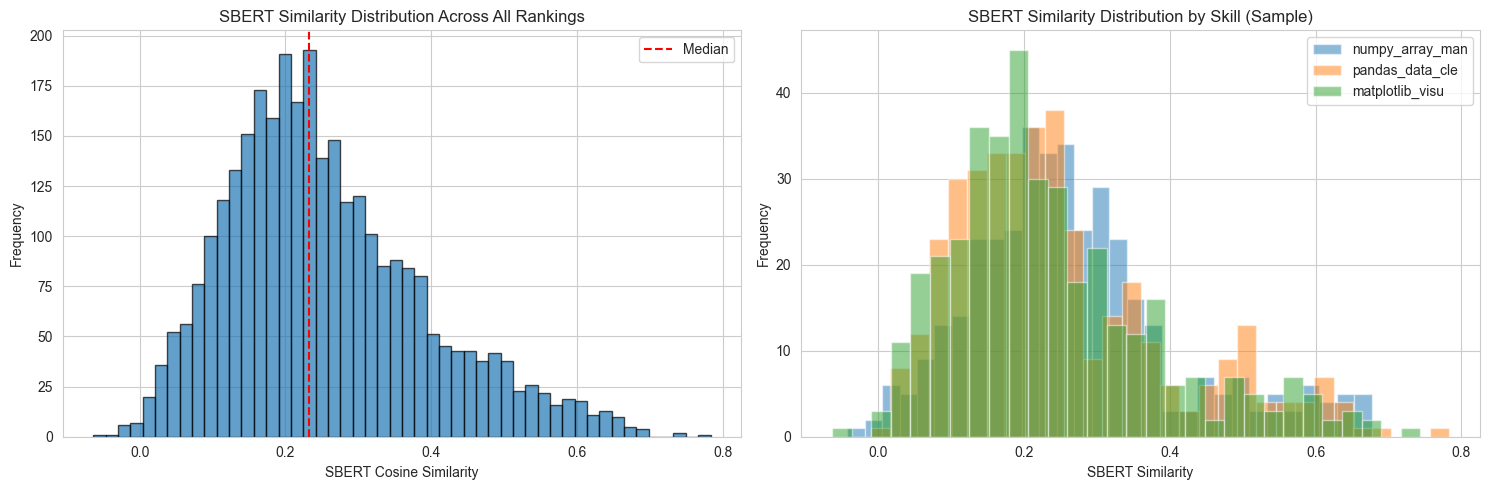


SBERT Similarity Statistics:
count    3072.000000
mean        0.255217
std         0.137198
min        -0.063570
25%         0.157660
50%         0.232989
75%         0.332784
max         0.783413
Name: sbert_similarity, dtype: float64


In [ ]:
# Visualize SBERT similarity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Similarity distribution
axes[0].hist(sbert_rankings_df['sbert_similarity'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('SBERT Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SBERT Similarity Distribution Across All Rankings')
axes[0].axvline(sbert_rankings_df['sbert_similarity'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Similarity distribution by skill
for skill in skills_config['skills'][:3]:  # Show first 3 skills
    skill_scores = sbert_rankings_df[sbert_rankings_df['skill_id'] == skill['skill_id']]['sbert_similarity']
    axes[1].hist(skill_scores, bins=30, alpha=0.5, label=skill['skill_id'][:15])

axes[1].set_xlabel('SBERT Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('SBERT Similarity Distribution by Skill (Sample)')
axes[1].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sbert_similarity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSBERT Similarity Statistics:")
print(sbert_rankings_df['sbert_similarity'].describe())

---
## Step 8: Save Results

In [ ]:
# Save SBERT rankings
output_path = RESULTS_DIR / 'sbert_rankings.csv'
sbert_rankings_df.to_csv(output_path, index=False)


# Save top-10 per skill for quick inspection
top10_per_skill = sbert_rankings_df[sbert_rankings_df['rank'] <= 10].copy()
top10_per_skill = top10_per_skill.merge(videos_df[['video_id', 'title']], on='video_id')

top10_path = RESULTS_DIR / 'sbert_top10_per_skill.csv'
top10_per_skill.to_csv(top10_path, index=False)


# Save chunk rankings
chunk_output_path = RESULTS_DIR / 'sbert_chunk_scores.csv'
sbert_chunk_rankings_df.to_csv(chunk_output_path, index=False)


---
## Step 9: Inspect Top Results per Skill

In [ ]:
# Show top-10 for each skill
for skill in skills_config['skills']:
    skill_id = skill['skill_id']
    print(f"\n{'='*80}")
    print(f"Top 10 videos for: {skill['name']}")
    print(f"{'='*80}")

    top_videos = sbert_rankings_df[
        (sbert_rankings_df['skill_id'] == skill_id) &
        (sbert_rankings_df['rank'] <= 10)
    ].merge(videos_df[['video_id', 'title']], on='video_id')

    for idx, row in top_videos.iterrows():
        print(f"{row['rank']:2d}. [{row['sbert_similarity']:.4f}] {row['title'][:70]}")


Top 10 videos for: NumPy array manipulation
 1. [0.6772] Mastering NumPy Array Manipulation Techniques
 2. [0.6744] ARRAYS in Python - Start Here!
 3. [0.6631] Python for Data Analysis: Numpy Arrays
 4. [0.6599] Python NumPy Tutorial | NumPy Array | Python Tutorial For Beginners | 
 5. [0.6550] NumPy Full Course (2025) | NumPy Python Tutorial For Beginners | Learn
 6. [0.6487] NumPy for Beginners in 15 minutes | Python Crash Course
 7. [0.6397] NumPy Full Python Course - Data Science Fundamentals
 8. [0.6395] Learn NumPy in 1 hour! 🔢
 9. [0.6393] Data Analysis with Python - Full Course for Beginners (Numpy, Pandas, 
10. [0.6382] 05  NymPy | Numerical Python | 3-Dimensional Image Array Manipulation:

Top 10 videos for: Pandas data cleaning
 1. [0.7834] Pandas Power - Mastering Data Cleaning and Preprocessing | Python for 
 2. [0.6851] Data Cleaning with Python (Full Course) | Step-by-Step Guide for Data 
 3. [0.6753] Data Analysis with Python - Full Course for Beginners (Numpy, Pandas,